# SD212: Graph mining
## Lab 2: Graph structure

In this lab, you will learn to:
* plot the degree distribution and observe the [power-law](https://en.wikipedia.org/wiki/Power_law#Power-law_probability_distributions),
* estimate the [diameter](https://en.wikipedia.org/wiki/Distance_(graph_theory)) of a graph and observe the [small-world](https://en.wikipedia.org/wiki/Small-world_network) property,
* estimate the [clustering coefficient](https://en.wikipedia.org/wiki/Clustering_coefficient) of a graph.

## Import

In [1]:
from IPython.display import SVG

In [2]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

In [3]:
from sknetwork.data import load_netset, erdos_renyi, cyclic_graph, karate_club
from sknetwork.path import distance, diameter, shortest_path
from sknetwork.utils import bipartite2undirected
from sknetwork.topology import Triangles
from sknetwork.visualization import svg_graph

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paris.fr) collection for details):
* Openflights (graph)
* WikiVitals (digraph)
* Cinema (bigraph)

In [4]:
openflights = load_netset('openflights')

Parsing files...
Done.


In [5]:
# focus on degrees, not weights
adjacency = (openflights.adjacency > 0)

In [6]:
wikivitals = load_netset('wikivitals')

Parsing files...
Done.


In [7]:
cinema = load_netset('cinema')

Parsing files...
Done.


## 1. Power law

We first focus on the power law degree distribution.

We consider the empirical distributions of:
* degrees in the Openflights graph,
* out-degrees and in-degrees in the WikiVitals graph.

## To do

For each of these distributions:
* Compute the [coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) and compare it to that of a Poisson distribution with the same mean.
* Plot the [tail distribution](https://en.wikipedia.org/wiki/Cumulative_distribution_function#Complementary_cumulative_distribution_function_(tail_distribution)) in log-log scale and compare it to that of an equivalent [Erdos-Rényi](https://en.wikipedia.org/wiki/Erdős–Rényi_model) graph (same number of nodes, same average degree).
* Conclude: do you consider that the degree distributions of these graphs have a power law?

In [8]:
n = adjacency.shape[0]
degrees = adjacency.dot(np.ones(n))

In [9]:
adjacency_random = erdos_renyi(n, np.mean(degrees)/n)
degrees_random = adjacency_random.dot(np.ones(n))

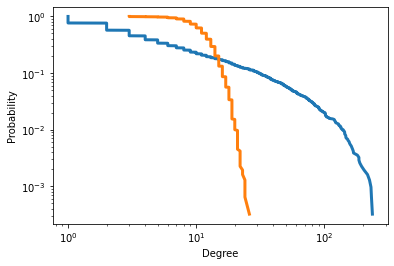

In [10]:
plt.loglog(np.sort(degrees), 1 - np.arange(n) / n, lw = 3)
plt.loglog(np.sort(degrees_random), 1 - np.arange(n) / n, lw = 3)
plt.xlabel('Degree')
plt.ylabel('Probability')
plt.show()

## 2. Small-world

You will now make a few experiments highlighting the small-world property.

## To do

* Complete the following function computing the distances from any given node in number of hops.
* Check your code with the function ``distance``.
* Give ones of the longest shortest paths starting from **Paris Charles de Gaulle** airport in Openflights.<br> 
You might use the function ``shortest_path``.<br>
List the corresponding airports and display the path.

In [11]:
def get_distances(adjacency: sparse.csr_matrix, source: int) -> np.ndarray:
    '''Get distances from a source node in number of hops.
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph.
    source:
        Source node
    
    Returns
    -------
    distances:
        Vector of distances.
    '''
    n = adjacency.shape[0]
    distances = np.inf * np.ones(n)
    distances[source] = 0
    reached = np.zeros(n).astype(bool)
    reached[source] = True
    stop = False
    t = 0
    while not stop:
        t += 1
        reached_new = adjacency.T.dot(reached)
        reached_new[reached] = False 
        distances[reached_new] = t
        reached[reached_new] = True 
        
        stop = sum(reached_new) == 0 
    return distances

In [12]:
adjacency = openflights.adjacency > 0
distances = get_distances(adjacency, 0)

In [13]:
dist = distance(adjacency, 0)
print(sum(distances != dist))

0


In [14]:
cdg = 622
airports = openflights.names
print(airports[cdg])

Charles de Gaulle International Airport


In [15]:
distances = get_distances(adjacency, cdg)
dest = np.argmax(distances)

In [16]:
def get_adjacency_path(adjacency, path):
    '''Return a path as an adjacency matrix (subset of edges).'''
    row = path[:-1]
    col = path[1:]
    data = np.ones(len(row), dtype=bool)
    adjacency_path = sparse.csr_matrix((data, (row, col)), shape=adjacency.shape)
    return adjacency_path

In [18]:
# a random shortest path

print(airports[cdg], '->', airports[dest])
path = shortest_path(adjacency, cdg, dest)

Charles de Gaulle International Airport -> Peawanuck Airport


In [19]:
# representation as a sparse matrix
adjacency_path = get_adjacency_path(adjacency, path)

In [20]:
# display
position = openflights.position
image = svg_graph(adjacency_path, position, directed=True, height=400, width=800, 
                  node_size=1, edge_width=3, edge_color='blue')

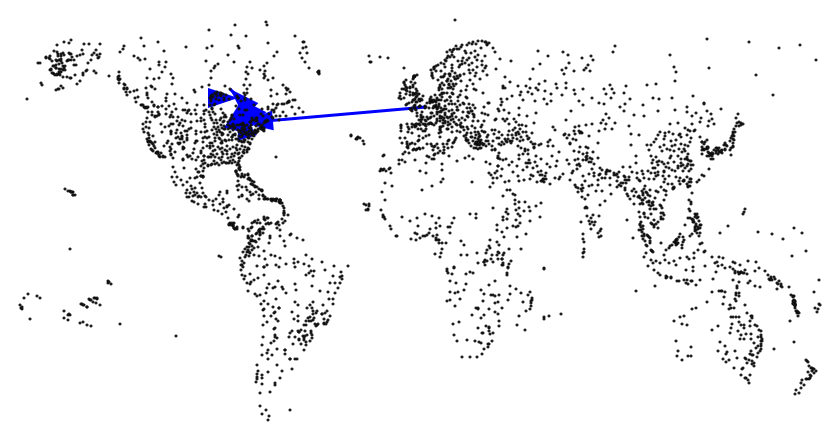

In [21]:
SVG(image)

## To do

* Which fraction of the airports can be reached from **Paris Charles de Gaulle** in 1, 2, 3 flights?
* Which fraction of the articles can be reached from **Paris** in 1, 2, 3 clicks on Wikipedia Vitals?

In [22]:
reached = [d<4 for d in distances]
print(sum(reached))

2815


In [23]:
wiki_adjacency = (wikivitals.adjacency > 0)
pages = wikivitals.names
source = np.where(pages=="Paris")[0][0]
print(source)

distances = get_distances(wiki_adjacency, source)
reached = [d<4 for d in distances]
print(sum(reached))

3279
9943


## To do

The following function estimates the [diameter](https://en.wikipedia.org/wiki/Distance_(graph_theory)) of a graph.

* Write a function giving the corresponding path (longest shortest path).
* Give a path of **length 12** in Openflights (with the airport names) and display it.
* Give a path of **length 6** in WikiVitals (with the names of the articles).

In [24]:
def estimate_diameter(adjacency: sparse.csr_matrix, n_samples=100) -> int:
    '''Estimate the diameter of a graph (longest shortest path).
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph.
    n_samples:
        Number of samples.
    
    Returns
    -------
    diameter:
        Estimation of the diameter. 
    '''    
    n = adjacency.shape[0]
    # start from random nodes
    nodes = np.random.choice(n, size=n_samples)
    distances = distance(adjacency.T, sources=nodes)
    distances[distances == np.inf] = -1
    # get the corresponding furthest nodes
    nodes_far = distances.argmax(axis=1)    
    distances = distance(adjacency, sources=nodes_far)
    distances[distances == np.inf] = -1
    # take the longest shortest path from these nodes 
    diameter = distances.max()
    return int(diameter)

In [25]:
estimate_diameter(adjacency)

12

In [26]:
estimate_diameter(wiki_adjacency)

6

In [27]:
def estimate_diameter_path(adjacency: sparse.csr_matrix, n_samples=100) -> int:
    '''Return a path of length equal to the (estimated) diameter of a graph.
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph.
    n_samples:
        Number of samples.
    
    Returns
    -------
    path:
        List of nodes. 
    '''    
    n = adjacency.shape[0]
    # start from random nodes
    nodes = np.random.choice(n, size=n_samples)
    distances = distance(adjacency.T, sources=nodes)
    distances[distances == np.inf] = -1
    # get the corresponding furthest nodes
    nodes_far = distances.argmax(axis=1)
    distances = distance(adjacency, sources=nodes_far)
    distances[distances == np.inf] = -1
    # take the longest shortest path from these nodes 
    source = np.argmax(np.max(distances, axis = 1))
    dest = np.argmax(distances[source])
    path = shortest_path(adjacency, source, dest)
    print(distances.max())
    return path

In [28]:
path = estimate_diameter_path(adjacency)
print(path, len(path))

12.0
[0, 4, 1040, 124, 85, 56, 2253, 2290, 2248, 2277] 10


## To do

* Compute the [Bacon number](https://fr.wikipedia.org/wiki/Six_Degrees_of_Kevin_Bacon) of all actors (**without** building the co-starring actor graph).
* Plot the corresponding histogram.
* Which fraction of actors have a Bacon number of 3 at most?

In [29]:
biadjacency = cinema.biadjacency

In [30]:
actor_adjacency = bipartite2undirected(biadjacency)

In [31]:
n_row = biadjacency.shape[0]

In [32]:
names = cinema.names_col

In [33]:
{i:name for i,name in enumerate(names) if 'Bacon' in name}

{2994: 'Frank Bacon',
 3465: 'Kevin Bacon',
 4052: 'Lloyd Bacon',
 10011: 'Irving Bacon',
 18496: 'Max Bacon',
 39070: 'David Bacon'}

In [34]:
bacon = n_row + 3465

In [35]:
distances = get_distances(actor_adjacency, bacon)
reached = [d<4 for d in distances]
print(sum(reached))

4914


(array([2.7300e+02, 3.9389e+04, 7.0846e+04, 1.9558e+04, 2.6590e+03,
        2.4100e+02, 2.9000e+01, 1.4000e+01, 1.1000e+01, 6.0000e+00]),
 array([ 0. ,  2.7,  5.4,  8.1, 10.8, 13.5, 16.2, 18.9, 21.6, 24.3, 27. ]),
 <BarContainer object of 10 artists>)

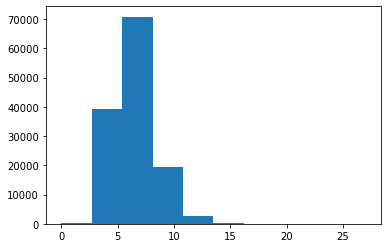

In [36]:
plt.hist(distances)

In [37]:
{i:name for i,name in enumerate(names) if 'Bellucci' in name}

{2644: 'Monica Bellucci', 7325: 'Carlos Bellucci'}

In [38]:
bellucci = n_row + 2644
print(len(shortest_path(actor_adjacency, bacon, bellucci)))

5


## 3. Clustering coefficient

The computation of the clustering coefficient of a graph is time-consuming.
You will now learn to **estimate** it.

## To do


* Complete the following function to estimate the clustering coefficient of a graph.
* Check your code on the triange, then on the karate club graph using ``Triangles``.
* Estimate the clustering coefficient of Openflights and WikiVitals (seen as an undirected graph) and compare with that of equivalent Erdos-Rényi graphs (same number of nodes, same average degree).

**Hint:** A triangle is... a cycle of length 3

In [39]:
def get_clustering_coefficient(adjacency: sparse.csr_matrix, n_samples: int = 100) -> float:
    '''Get the clustering coefficient of a graph.
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph (binary).
    
    Returns
    -------
    clustering_coef:
        Clustering coefficient.
    '''
    clustering_coef = 0
    # sample nodes
    n = adjacency.shape[0]
    if n_samples < n:
        nodes = np.random.choice(n, size=n_samples, replace=False)
    else:
        nodes = np.arange(n)
    # compute the clustering coefficient for these samples
    # to be modified
    clustering_coef = 0
    return clustering_coef

In [40]:
triangle = cyclic_graph(3)

In [41]:
algo = Triangles()

In [42]:
algo.fit(triangle)

Triangles(parallelize=False)

In [43]:
algo.clustering_coef_

1.0

In [44]:
get_clustering_coefficient(triangle)

0